<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/NLP_Fundamentals_in_TensorFlow_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Natural Language Processing Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2sep)
E.g. One-2-One, Many-2-One, and so on...

### Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c7fb30e7-1c01-f1f6-a263-ae63da639110)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py

# Import series of helper functions for the notebook
from helper import *

--2024-03-30 11:15:38--  https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16634 (16K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.24K  --.-KB/s    in 0.001s  

2024-03-30 11:15:38 (29.6 MB/s) - ‘helper.py’ saved [16634/16634]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

[Kaggle Competition](https://www.kaggle.com/competitions/nlp-getting-started)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
DataHandler.unzip_data('nlp_getting_started.zip')

--2024-03-30 11:15:42--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-03-30 11:15:43 (118 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to use pandas.

In [4]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# shuffling our training data
train_df = train_df.sample(frac=1, random_state=42)
train_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does our test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# Total samples
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random

random_idx = random.randint(0, len(train_df) - 5)
for row in train_df[['text', 'target']][random_idx:random_idx + 5].itertuples():

    _, text, target = row
    print(f'Target: {target}', "(real disaster)" if target > 0 else "(not real disaster)")
    print(f'Text:\n {text}\n')

    print('---\n')

Target: 1 (real disaster)
Text:
 Carolina accident: Motorcyclist Dies in I-540 Crash With Car That Crossed Median: A motorcycle rider traveling... http://t.co/p18lzRlmy6

---

Target: 1 (real disaster)
Text:
 Governor Allows Parole for School Bus Hijacker http://t.co/liKWQhSHHX via @nbcnews I remember this crime sent chills through parents

---

Target: 0 (not real disaster)
Text:
 @jaureguiswisdom lmao well i only know one and ive only had a crush on this one sooo

---

Target: 0 (not real disaster)
Text:
 @Hollyorange8 my day has been a disaster of emotions

---

Target: 0 (not real disaster)
Text:
 Aw man. 'Apollo Crews' just screams 'we can't think of a name for this black guy quick name some and mash them together'

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

train_sen, val_sen, train_labels, val_labels = train_test_split(train_df['text'].to_numpy(),
                                                                train_df['target'].to_numpy(),
                                                                test_size=0.1, random_state=42)
# Check the lengths
len(train_sen), len(train_labels), len(val_sen), len(val_labels)

(6851, 6851, 762, 762)

In [11]:
# Check the first 10 samples
train_sen[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert the text into numbers.

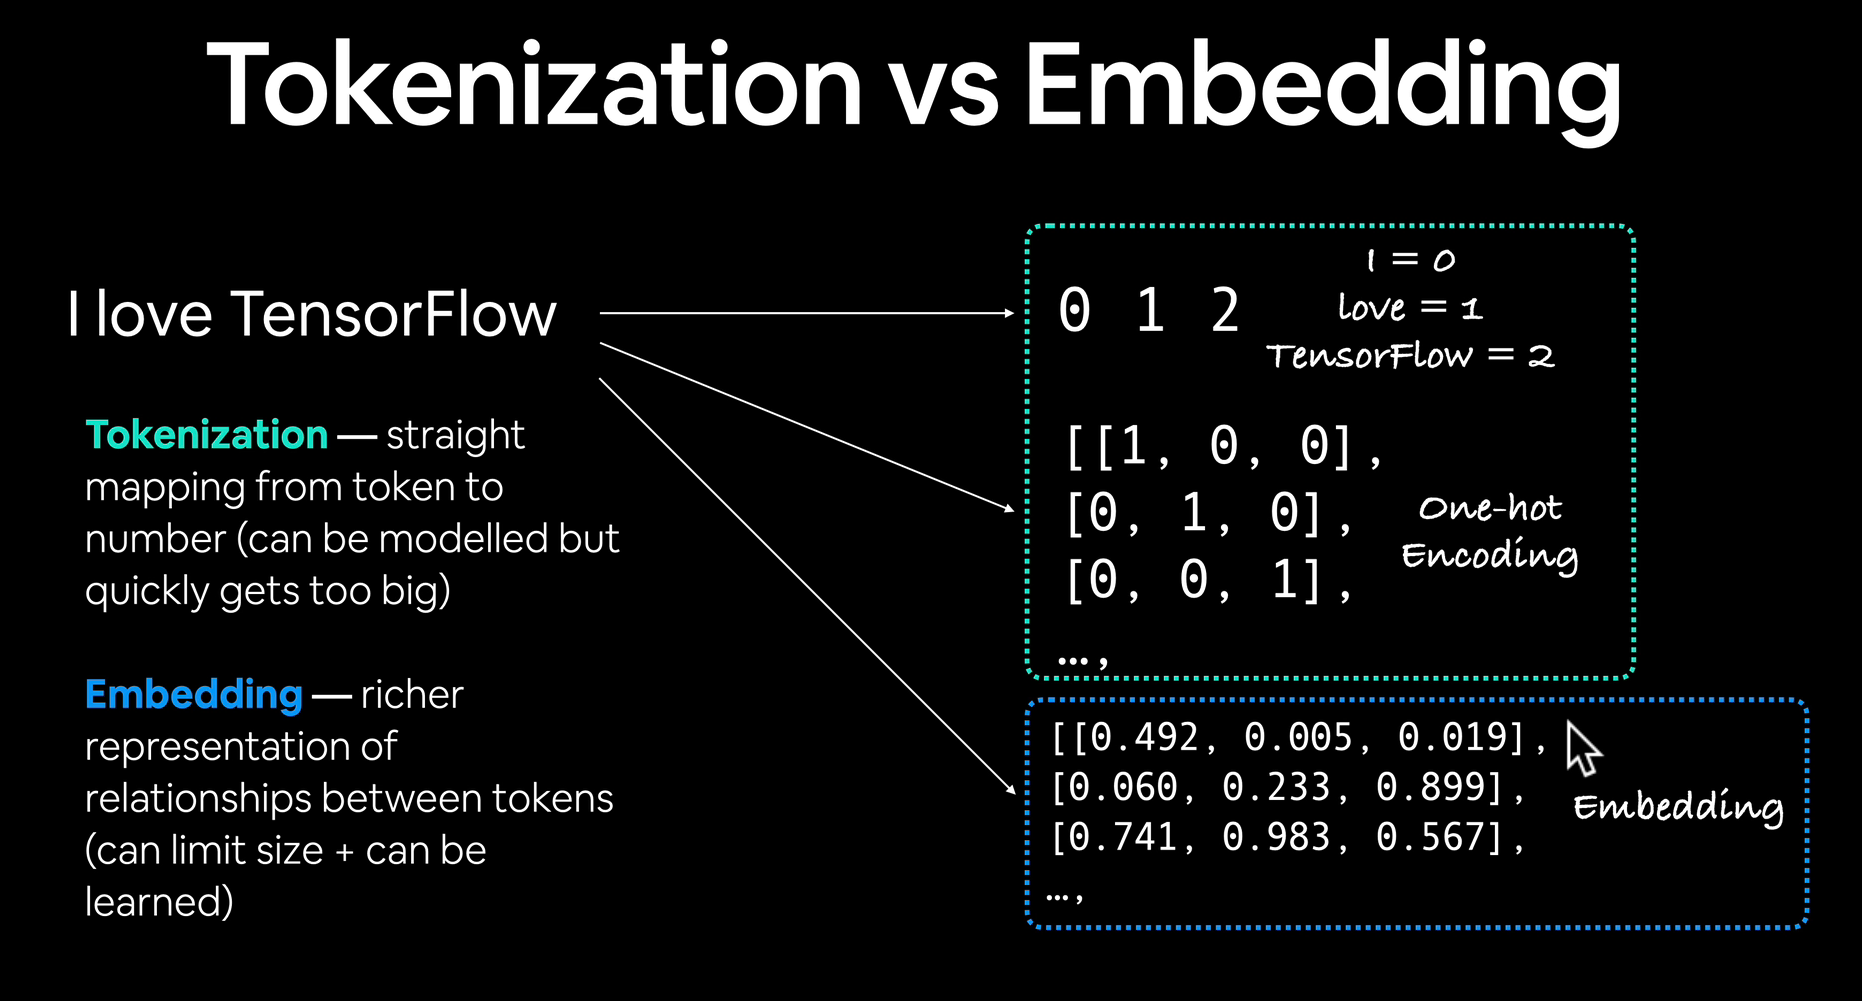

### Text vectorization (Tokenization)

In [12]:
train_sen[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000,  # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation', split='whitespace',
                                    ngrams=None,  # creates groups of n-words
                                    output_mode='int',  # how to map tokens to numbers
                                    output_sequence_length=None,  # how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [14]:
len(train_sen[0].split())

7

In [15]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sen])/len(train_sen))

15

In [16]:
# Setup text vectorization variables
max_vocab_length = 10000 # @param {type:"slider", min:2000, max:10000, step:2000}
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

# Fit the text vectorizer to the training data
text_vectorizer.adapt(train_sen)  # adapt the text vectorizer to the training data

In [17]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [18]:
# Choose a random sentence from the training data
random_sentence = random.choice(train_sen)
print(f'Original text:\n {random_sentence}\
        \n\nVectorized version:\n {text_vectorizer([random_sentence])}')

Original text:
 I'm in utter shock and devastation you don't go to work to be left feeling how I do now. Life really is too short ??        

Vectorized version:
 [[  32    4 2625 3422    7  515   12   63  112    5  166    5   21  601
   707]]


In [19]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words from the training data
print(f'Number of unique words in the vocabulary: {len(words_in_vocab)}')  # print the number of unique words in the vocabulary

top_5_words = words_in_vocab[:5]  # get the top 5 words
print(f'Top 5 words in the vocabulary:\n {top_5_words}')

bottom_5_words = words_in_vocab[-5:]  # get the bottom 5 words
print(f'Bottom 5 words in the vocabulary:\n {bottom_5_words}')

Number of unique words in the vocabulary: 10000
Top 5 words in the vocabulary:
 ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words in the vocabulary:
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a avalue of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [20]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length,  # set input shape
                            output_dim=128,  # set output shape
                            embeddings_initializer='uniform',  # set initializer
                            input_length=max_length  # how long is each input
                            )
embedding

In [21]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sen)
print(f'Original text:\n {random_sentence}\
        \n\nEmbedded version:\n {embedding(text_vectorizer([random_sentence]))}\n Tensor Shape: {embedding(text_vectorizer([random_sentence])).shape}')  # vectorize the sentence

Original text:
 Let's not forget our wounded female veterans. http://t.co/rZ7fbr10xw        

Embedded version:
 [[[ 0.03544906 -0.04193763 -0.03885459 ... -0.02170979  0.00042326
    0.03528051]
  [-0.00446093  0.03028053  0.03550159 ... -0.00603215  0.02215871
    0.03486223]
  [ 0.02539762 -0.04130827  0.04778364 ...  0.03264971  0.03364745
    0.00525888]
  ...
  [ 0.00207418  0.00975268  0.04665167 ... -0.03844026 -0.04668645
    0.01555553]
  [ 0.00207418  0.00975268  0.04665167 ... -0.03844026 -0.04668645
    0.01555553]
  [ 0.00207418  0.00975268  0.04665167 ... -0.03844026 -0.04668645
    0.01555553]]]
 Tensor Shape: (1, 15, 128)


In [22]:
# Check out a single token's embedding
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03544906, -0.04193763, -0.03885459,  0.04946562,  0.02367742,
         0.0403662 ,  0.0406071 , -0.04428343,  0.04296878,  0.03273067,
         0.01067978, -0.04367334,  0.0442048 , -0.01954379,  0.04089442,
        -0.04127352,  0.0203822 , -0.04346141,  0.04555598,  0.02221337,
        -0.02190647,  0.00730506,  0.04280088,  0.02624207, -0.01526459,
         0.0423107 , -0.00135604, -0.03885789, -0.00777416,  0.00694512,
        -0.01344113,  0.00371978, -0.0425794 ,  0.04082388, -0.01399866,
         0.02203827,  0.03033138,  0.0278945 , -0.01231375, -0.02597739,
        -0.02701812,  0.04128796, -0.04377425, -0.01903999,  0.0079692 ,
        -0.03506345,  0.02193328, -0.01219674, -0.01220776,  0.04277858,
         0.01257365,  0.02299391, -0.02133931,  0.00758439, -0.01695385,
        -0.01171082,  0.00387983, -0.0148899 ,  0.04427114, -0.04420775,
        -0.02080847, -0.00253107,  0.02777395,  0.03688781, -0.0024213 ,
  

## Modelling a text dataset (running a series of experiments)

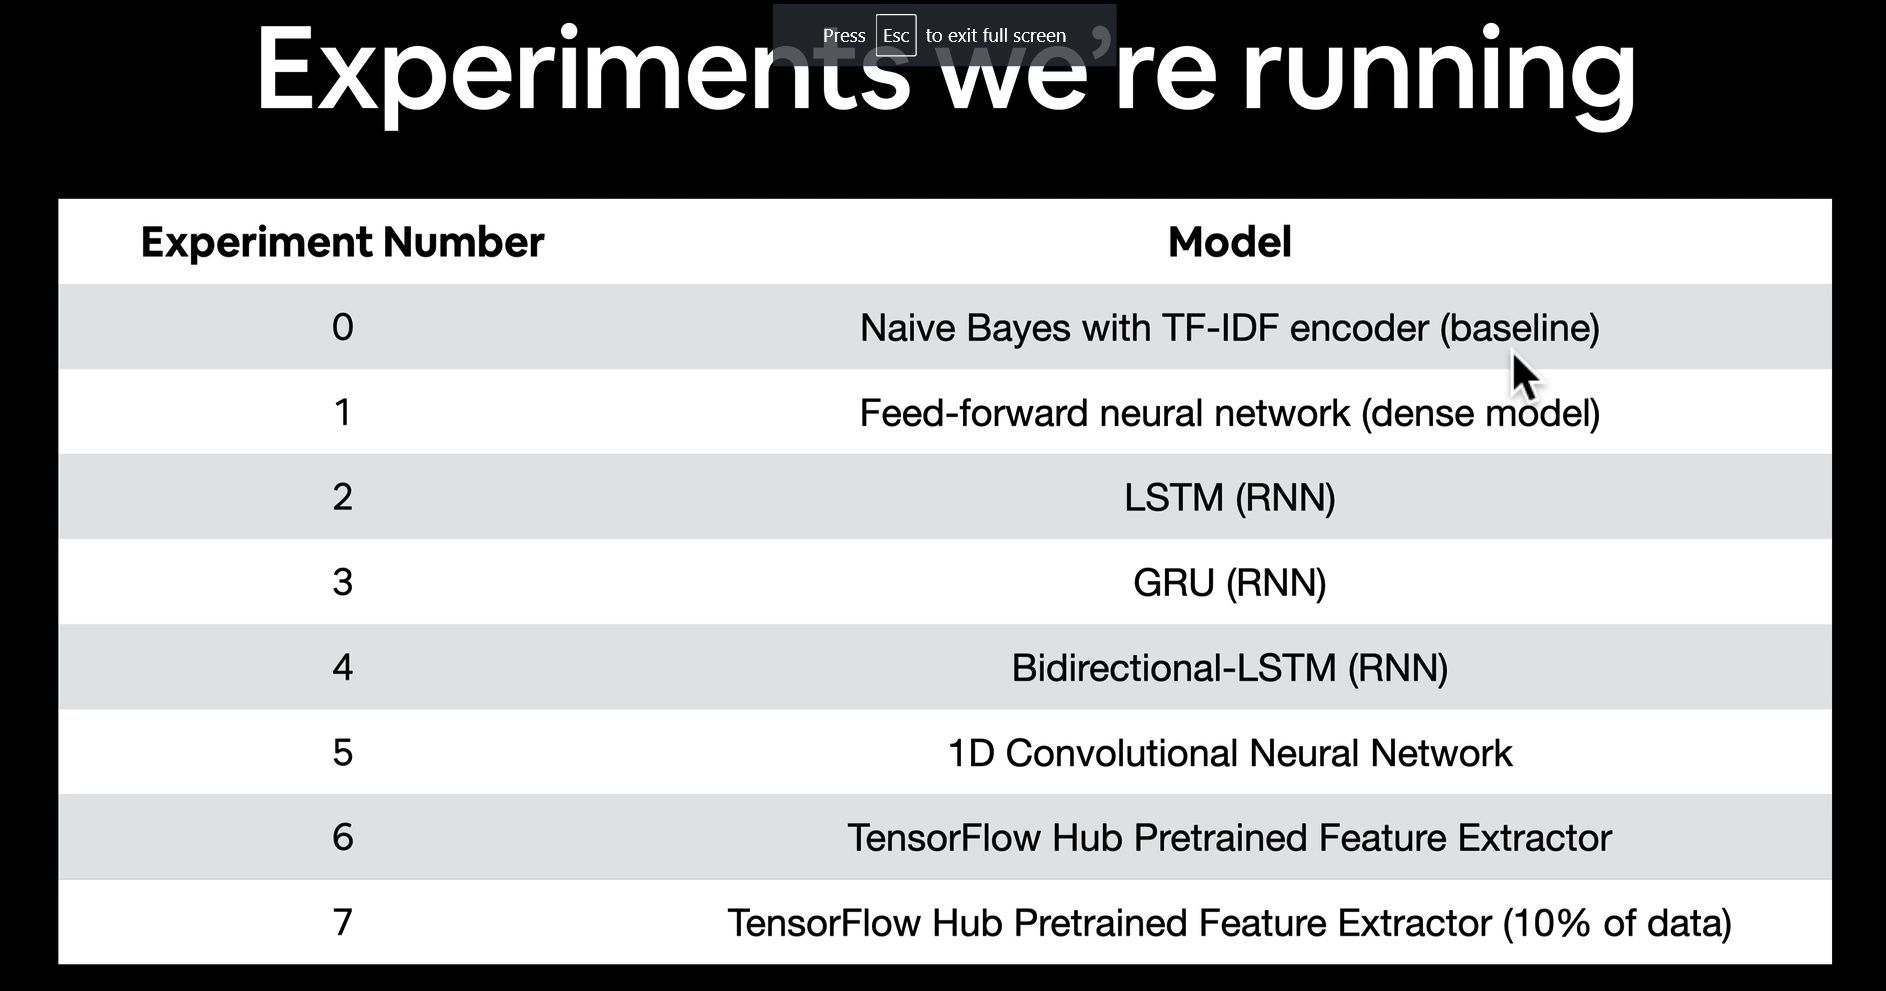

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model_0: [Naive Bayes](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (baseline), this is from [Sklearn ML map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* Model_1: Feed-Forward neural network (dense model)
* Model_2: LSTM model (RNN)
* Model_3: GRU model (RNN)
* Model_4: Bidirectional-LSTM model (RNN)
* Model_5: 1D Convolutional Neural Network (CNN)
* Model_6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model_7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling tensorFlow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

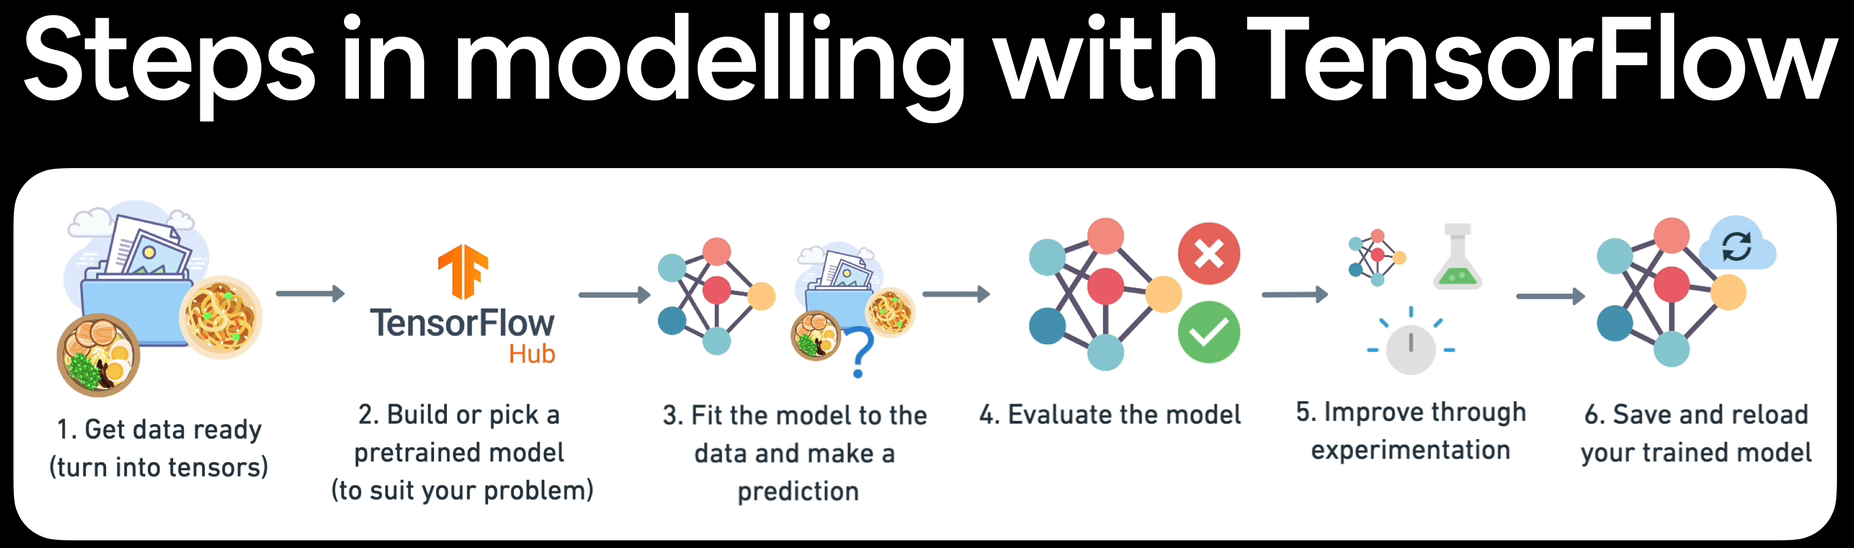

### Model_0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to buil upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **🔑 Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ('vect', TfidfVectorizer()),  # convert words to numbers using tfidf
    ('clf', MultinomialNB()),  # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sen, train_labels)

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sen, val_labels)
print(f'Baseline score: {baseline_score*100:.2f}%')

Baseline score: 79.27%


In [25]:
# Make predictions
baseline_predictions = model_0.predict(val_sen)
baseline_predictions[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [26]:
# Let's look at some other metrics
ModelEvaluation.results(baseline_predictions, val_labels)

{'accuracy': 79.26509186351706,
 'precision': 0.8336022277575122,
 'recall': 0.7926509186351706,
 'f1': 0.7990828614653861}

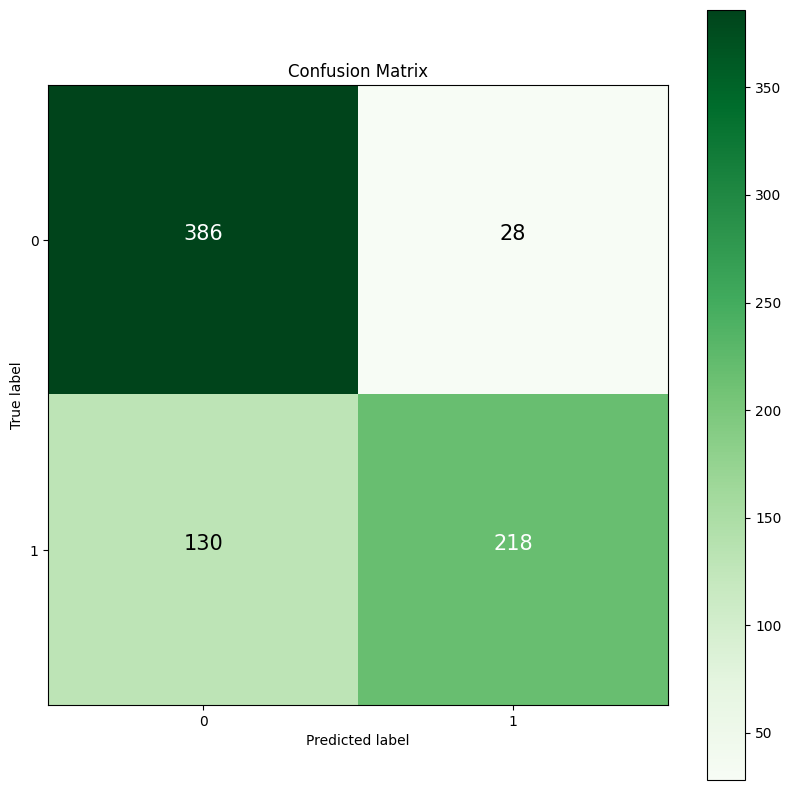

In [27]:
# Make a confusion metrics based on predictions
ModelEvaluation.make_confusion_matrix(val_labels, baseline_predictions)

In [28]:
# f'{(386 + 218) / (386 + 218 + 130 + 28) * 100:.2f}%'

### Model_1: Feed Forward neural network

Let's create a simple dense model and this will be our first deep learning model.

In [29]:
# Create a tensorboard callback
SAVE_DIR = 'model_logs'

# Build a model with the Functional API
import tensorflow as tf
from tensorflow.keras import layers
imputs = layers.Input(shape=(1,), dtype=tf.string)  # inputs are 1-dimensional strings
x = text_vectorizer(imputs)  # convert strings to numbers
x = embedding(x)  # create an embedding layer to numberize inputs
x = layers.GlobalAveragePooling1D()(x)  # flatten the embedding layer
outputs = layers.Dense(1, activation='sigmoid')(x)  # create a dense layer
model_1 = tf.keras.Model(inputs=imputs, outputs=outputs, name='model_1_dense')  # create the model

model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [30]:
# Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_01 = model_1.fit(train_sen, train_labels,
                    epochs=5,
                    validation_data=(val_sen, val_labels),
                    callbacks=[Callback.create_tensorboard(SAVE_DIR, 'model_1_dense')])  # create a tensorboard callback

Saving TensorBoard log files to: model_logs/model_1_dense/20240330-111547
Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.6111 - accuracy: 0.6941 - val_loss: 0.5402 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4409 - accuracy: 0.8177 - val_loss: 0.4729 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3474 - accuracy: 0.8600 - val_loss: 0.4607 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2856 - accuracy: 0.8904 - val_loss: 0.4693 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2390 - accuracy: 0.9118 - val_loss: 0.4799 - val_accuracy: 0.7808


In [31]:
# Evaluate the model
model_1_score = model_1.evaluate(val_sen, val_labels)
print(f'Model_1 score: {model_1_score[1]*100:.2f}%')

24/24 [==============================] - 0s 3ms/step - loss: 0.4799 - accuracy: 0.7808
Model_1 score: 78.08%


In [32]:
# Evaluating the model on other metrics
model_1_preds = list(map(lambda x: 1 if x > 0.5 else 0, model_1.predict(val_sen)))
model_1_preds = np.array(model_1_preds)
ModelEvaluation.results(val_labels, model_1_preds)

24/24 [==============================] - 0s 4ms/step


{'accuracy': 78.08398950131233,
 'precision': 0.7848699684611963,
 'recall': 0.7808398950131233,
 'f1': 0.7779792730264676}

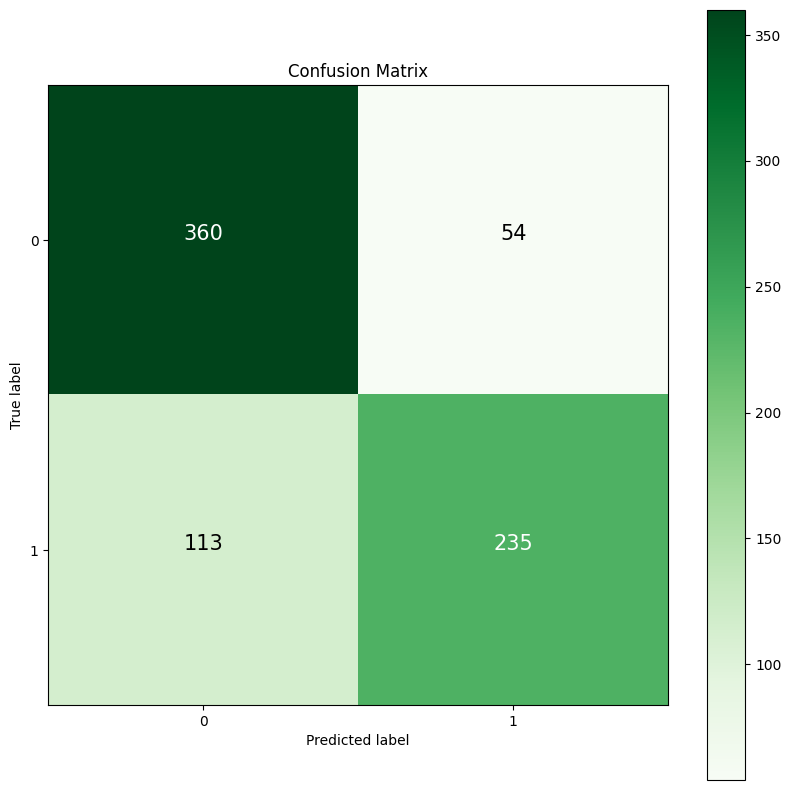

In [33]:
# Make a confusion matrix to visualize the predictions
ModelEvaluation.make_confusion_matrix(val_labels, model_1_preds)

In [34]:
# (352 + 233) / (352 + 233 + 115 + 62)

**Conclusion:** The baseline model out performs the first deep learning model
> *baseline*

{'accuracy': 79.26509186351706,
 'precision': 0.8336022277575122,
 'recall': 0.7926509186351706,
 'f1': 0.7990828614653861}

 > *dense_model*

 {'accuracy': 78.08398950131233,
 'precision': 0.7831507995990558,
 'recall': 0.7808398950131233,
 'f1': 0.7786634307220067}

## Visualizing learned embeddings

In [35]:
# Get the vocabulary from the text vectorization
vocab = text_vectorizer.get_vocabulary()
len(vocab), vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [36]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

> 📑**Resource:** https://jalammar.github.io/illustrated-word2vec/

In [37]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embedding_weights = model_1.get_layer('embedding').get_weights()[0]
embedding_weights, embedding_weights.shape

(array([[-0.00849533,  0.0224333 ,  0.06115112, ..., -0.05136053,
         -0.06144704,  0.00218695],
        [ 0.04370152,  0.04758188,  0.01283785, ...,  0.00862083,
          0.00261661, -0.00962766],
        [-0.0367755 , -0.01151247,  0.05300881, ...,  0.01672447,
         -0.03831787,  0.03254541],
        ...,
        [-0.01947862, -0.02805058,  0.03996856, ...,  0.04578466,
         -0.04114629, -0.02370753],
        [-0.01952362, -0.00352057,  0.02664392, ..., -0.07041316,
         -0.00365032, -0.04837689],
        [-0.06747121,  0.07864443,  0.04383994, ..., -0.10318288,
         -0.03919759, -0.09008258]], dtype=float32),
 (10000, 128))

In [38]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedding_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [39]:
# Download files from colab to upload into projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNNs are useful for sequential data

The premise of recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

- Refer to MIT's Introduction to Deep Learning: https://www.youtube.com/playlist?list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI
- Chris Olah's [intro to LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- Andrej Karpathy's [the unreasonable effectiveness of recurrent neural networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

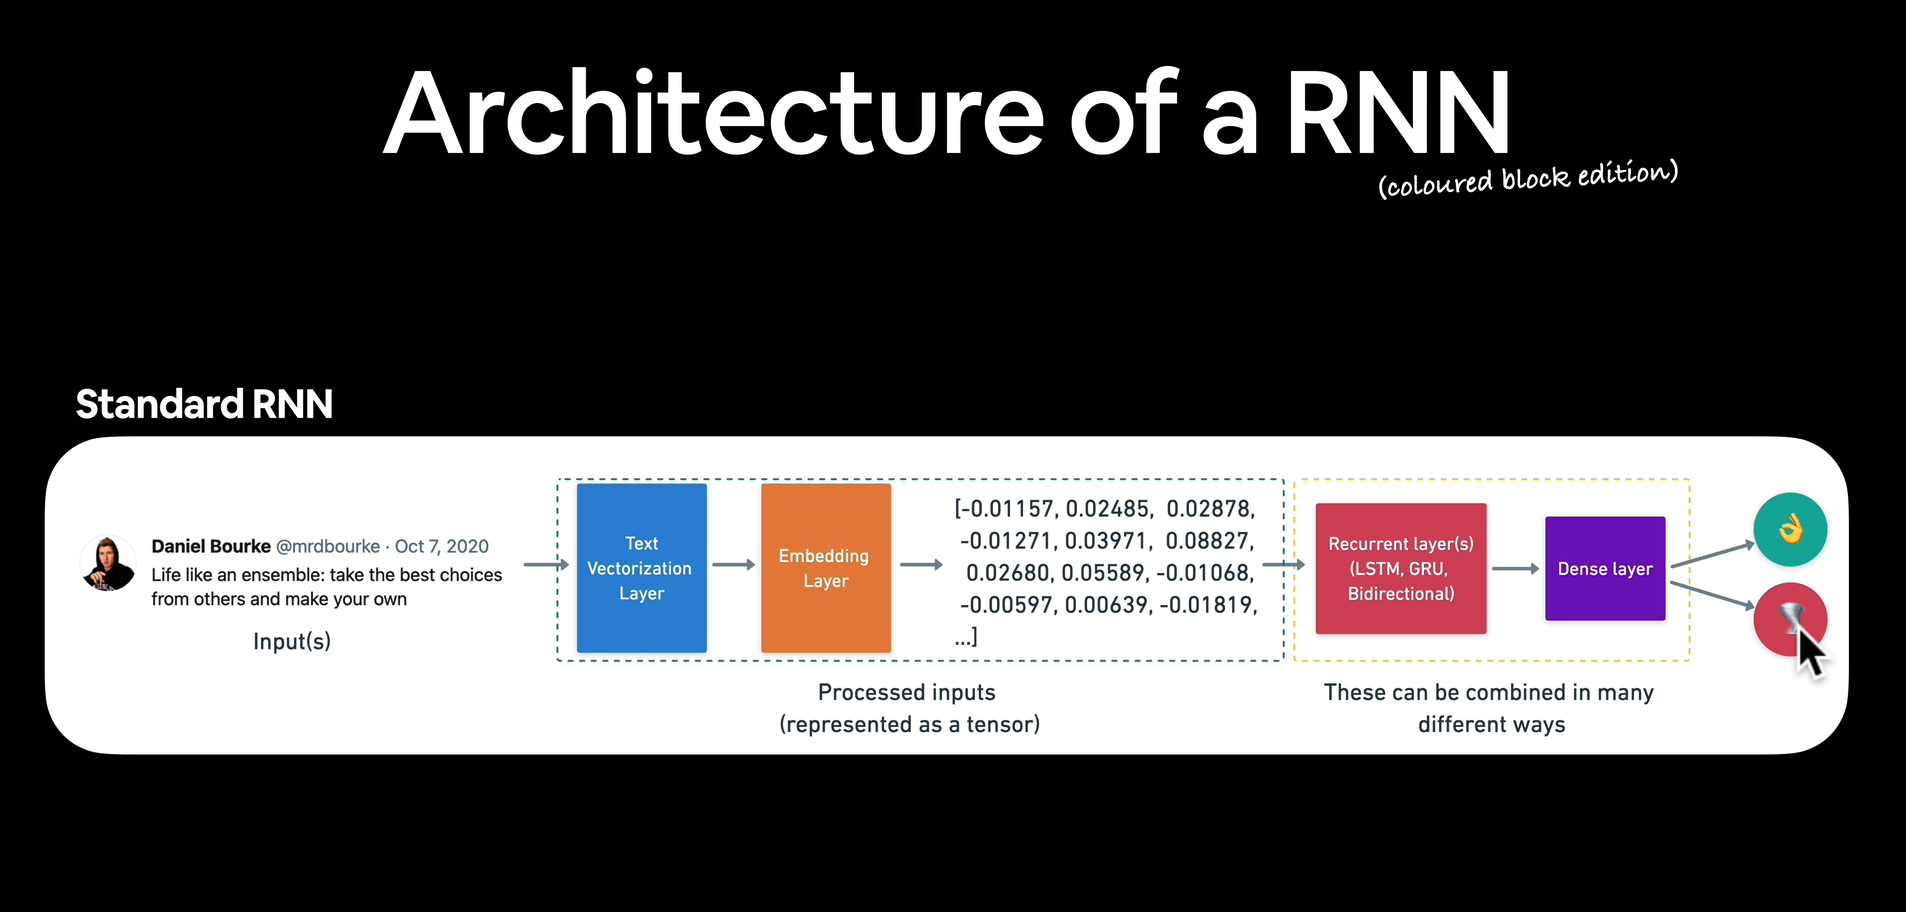

### Model_2: LSTM

LSTM = long short term memory (one of the most popular cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN/dense) -> Output (label probability)
```

In [40]:
# Create an LSTM model
from tensorflow import keras
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)  # when you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(inputs, outputs, name='model_2_LSTM')

In [41]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [42]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_02 = model_2.fit(train_sen, train_labels,
                         epochs=5,
                         validation_data=(val_sen, val_labels),
                         callbacks=[Callback.create_tensorboard(dir_name=SAVE_DIR, experiment_name='model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240330-111606
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.2214 - accuracy: 0.9229 - val_loss: 0.5790 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1553 - accuracy: 0.9409 - val_loss: 0.6162 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1280 - accuracy: 0.9496 - val_loss: 0.7238 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1036 - accuracy: 0.9612 - val_loss: 0.7133 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0854 - accuracy: 0.9660 - val_loss: 0.8123 - val_accuracy: 0.7782


In [43]:
# Make predictions and evaluate the model
model_2_preds = list(map(lambda x: 1 if x > 0.5 else 0, model_2.predict(val_sen)))
model_2_preds = np.array(model_2_preds)
ModelEvaluation.results(val_labels, model_2_preds)

24/24 [==============================] - 0s 3ms/step


{'accuracy': 77.82152230971128,
 'precision': 0.7814103276314137,
 'recall': 0.7782152230971129,
 'f1': 0.7756075024838144}

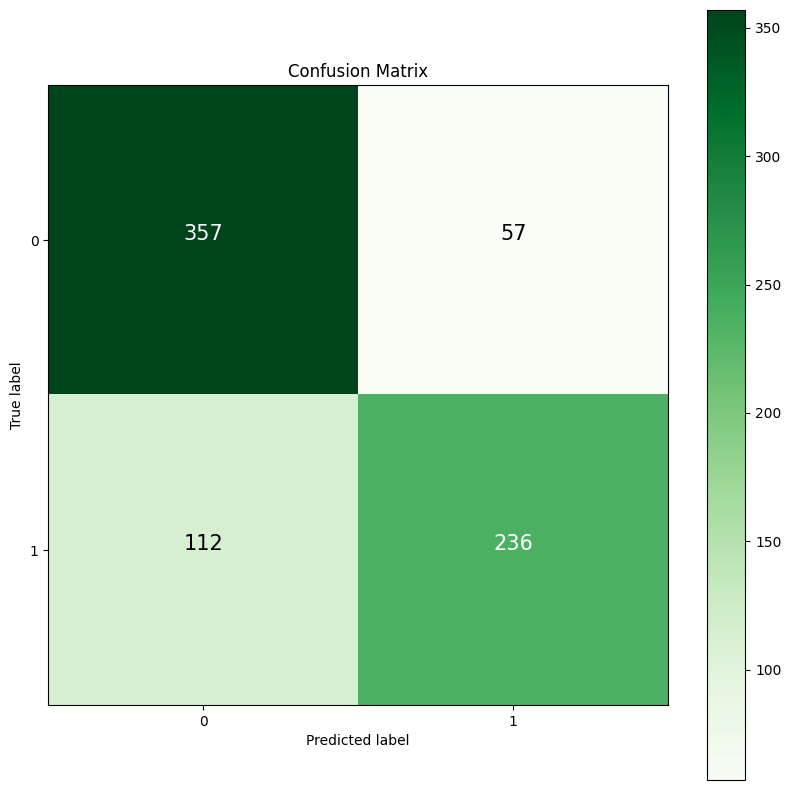

In [44]:
# Make a confusion matrix to visualize the predictions
ModelEvaluation.make_confusion_matrix(val_labels, model_2_preds)

### Model_3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters

In [45]:
# Create a GRU model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)  # if you want to stack recurrent layers on top of each other, you need to set return_sequence=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(inputs, outputs, name='model_3_GRU')

In [46]:
# Get the model summary()
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [47]:
# get the model summary()
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [48]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_03 = model_3.fit(train_sen, train_labels,
                         epochs=5,
                         validation_data=(val_sen, val_labels),
                         callbacks=[Callback.create_tensorboard(dir_name=SAVE_DIR, experiment_name='model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240330-111630
Epoch 1/5
215/215 [==============================] - 11s 41ms/step - loss: 0.1753 - accuracy: 0.9400 - val_loss: 0.6878 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1038 - accuracy: 0.9634 - val_loss: 0.8130 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0869 - accuracy: 0.9675 - val_loss: 0.9038 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0753 - accuracy: 0.9723 - val_loss: 0.8757 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0667 - accuracy: 0.9734 - val_loss: 1.0005 - val_accuracy: 0.7638


In [49]:
# Make predictions and Evalute the model
model_3_preds = list(map(lambda x: 1 if x > 0.5 else 0, model_3.predict(val_sen)))
model_3_preds = np.array(model_3_preds)
ModelEvaluation.results(val_labels, model_3_preds)

24/24 [==============================] - 0s 3ms/step


{'accuracy': 76.37795275590551,
 'precision': 0.7666261988309462,
 'recall': 0.7637795275590551,
 'f1': 0.7609269783019205}

### Model_4: Bidirectional LSTM

Normal RNN's go from left to right (just like you'd read an English sentences) however, a bidirectional RNN goes from left to right and right to left as well.

In [50]:
# Create a bidirectional LSTM
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)  # If we decide to stack bidirectional layers
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_4_bidirectional')

In [51]:
# Get the summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [52]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
model_4_history = model_4.fit(train_sen,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sen, val_labels),
                              callbacks=[Callback.create_tensorboard(SAVE_DIR, 'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240330-111653
Epoch 1/5
215/215 [==============================] - 13s 43ms/step - loss: 0.1081 - accuracy: 0.9667 - val_loss: 0.9691 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0589 - accuracy: 0.9759 - val_loss: 0.9619 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0499 - accuracy: 0.9784 - val_loss: 1.3253 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0459 - accuracy: 0.9803 - val_loss: 1.5435 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0452 - accuracy: 0.9791 - val_loss: 1.3201 - val_accuracy: 0.7664


In [53]:
# Make some predictions with our bidirectional model
model_4_preds = list(map(lambda x: 1 if x > 0.5 else 0, model_4.predict(val_sen)))
model_4_preds = np.array(model_4_preds)
ModelEvaluation.results(val_labels, model_4_preds)

24/24 [==============================] - 1s 3ms/step


{'accuracy': 76.64041994750657,
 'precision': 0.7666473890043123,
 'recall': 0.7664041994750657,
 'f1': 0.7665046359496325}

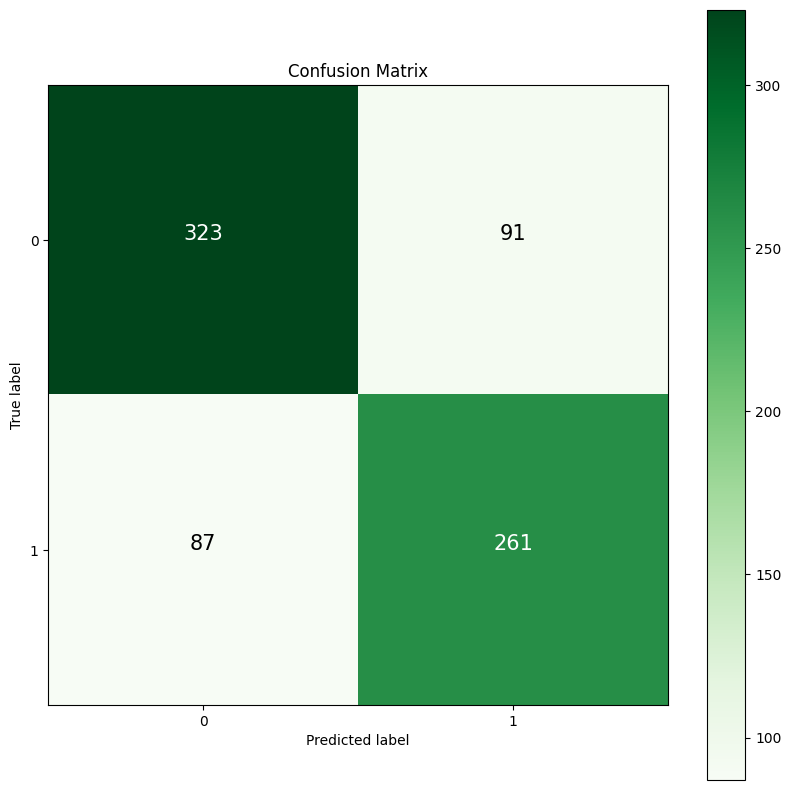

In [54]:
# Make a confusion matrix to visualize preds
ModelEvaluation.make_confusion_matrix(val_labels, model_4_preds)

### Model_5: 1D Convolutional Neural Networks

We've used CNNs for images but images our typically 2D (height x width)... however, out text data is 1D.

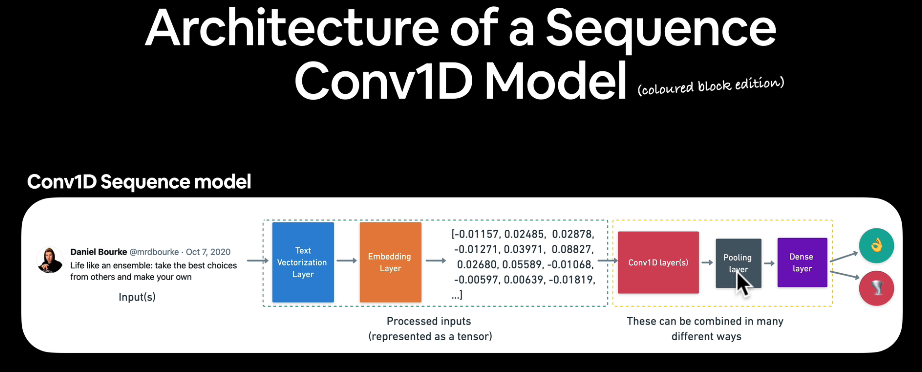

In [55]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['ipl is iplising']))  # turn target into numbers
conv_1d = layers.Conv1D(filters=32, kernel_size=5,
                        activation='relu', padding='valid')

conv_1d_output = conv_1d(embedding_test)  # pass test embeddding through conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)  # equivalent to 'get most important data'

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [56]:
# Create 1D CNN model
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

In [57]:
# Get the model summary
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [58]:
# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_05 = model_5.fit(train_sen, train_labels,
                         epochs=5,
                         validation_data=(val_sen, val_labels),
                         callbacks=[Callback.create_tensorboard(SAVE_DIR, 'model_5_conv1D')])

Saving TensorBoard log files to: model_logs/model_5_conv1D/20240330-111718
Epoch 1/5
215/215 [==============================] - 10s 39ms/step - loss: 0.1157 - accuracy: 0.9647 - val_loss: 0.9385 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0708 - accuracy: 0.9737 - val_loss: 1.0480 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0580 - accuracy: 0.9771 - val_loss: 1.1546 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0525 - accuracy: 0.9783 - val_loss: 1.2186 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0502 - accuracy: 0.9791 - val_loss: 1.2141 - val_accuracy: 0.7585


In [59]:
# Make some predictions
model_5_preds = list(map(lambda x: 1 if x > 0.5 else 0, model_5.predict(val_sen)))
model_5_preds = np.array(model_5_preds)
ModelEvaluation.results(val_labels, model_5_preds)

24/24 [==============================] - 0s 3ms/step


{'accuracy': 75.8530183727034,
 'precision': 0.7584850115306213,
 'recall': 0.7585301837270341,
 'f1': 0.7573131746360092}

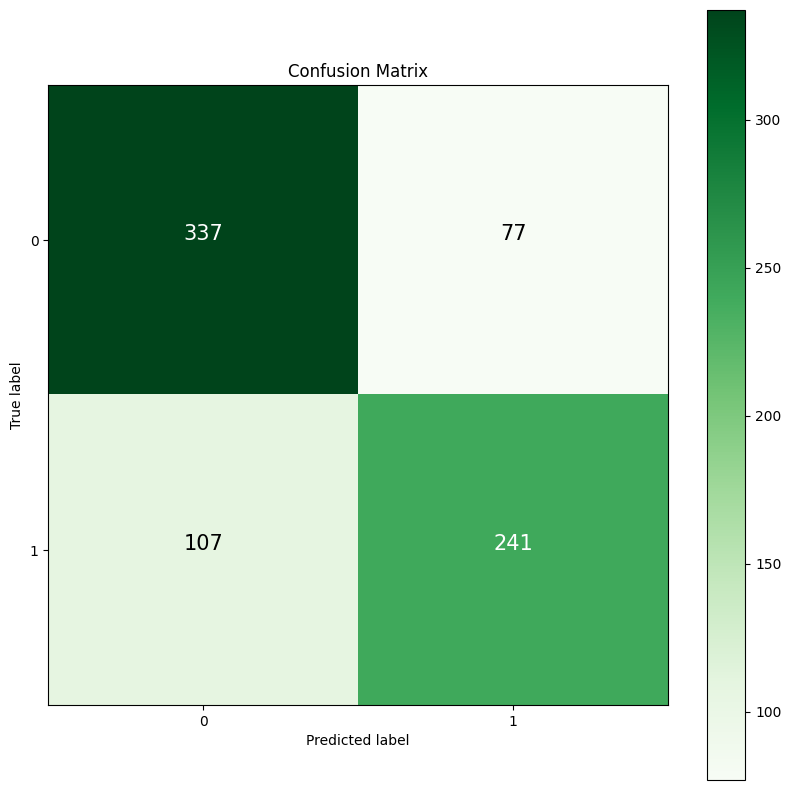

In [60]:
# Visualize the preds
ModelEvaluation.make_confusion_matrix(val_labels, model_5_preds)

### Model_6: TensorFlow Hub Pretrained Feature Extractor

In this model, we use a pre-trained model that will apply transfer learning to learn the patterns from the data.

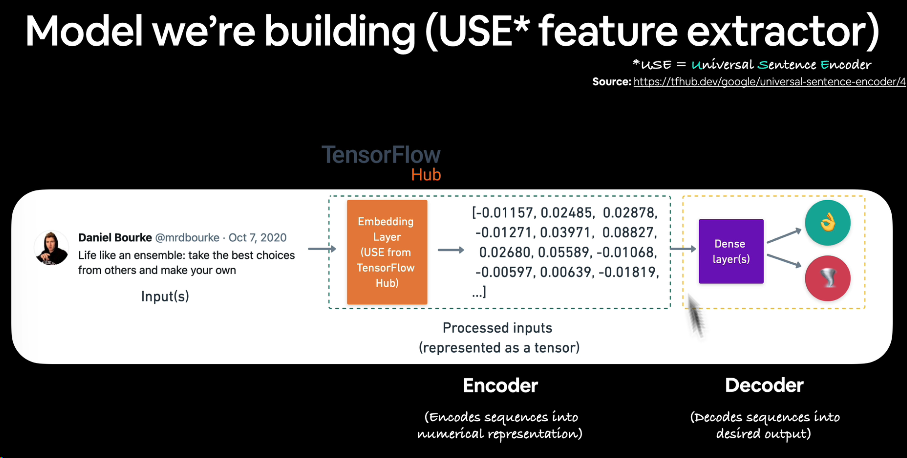

In [62]:
# Create a Pretrained Feature Extractor Model
import tensorflow_hub as hub
embed = hub.load('https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2')
embed_samples = embed([sample_sentence,
                      'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01602836  0.01068853  0.02425464 -0.01405768  0.01434428  0.08292627
  0.01963369  0.0616014  -0.00352701 -0.01216415  0.00978648 -0.01248499
  0.01232347  0.09748451  0.06141111 -0.03728352  0.01860887 -0.04669851
  0.00413913 -0.06363907 -0.02469896  0.02713692  0.02284444 -0.0021003
 -0.00630591 -0.0396496   0.02220407  0.00115075 -0.03132181  0.00119527
 -0.04012549  0.04561895 -0.01530597 -0.00175914  0.02173133 -0.08450424
  0.03340027  0.04604555 -0.0248025  -0.08681662  0.00702696 -0.00770477
 -0.01434536  0.07814164 -0.10676058 -0.05152996 -0.00858159 -0.0323223
 -0.03871096  0.02581471], shape=(50,), dtype=float32)


In [64]:
embed_samples[0].shape

TensorShape([512])

In [65]:
# Create a keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2',
                                  input_shape=[], dtype='string',
                                  trainable=False, name='USE')

In [72]:
# Create a model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_6_USE')

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the model summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [73]:
# Train a classifier on top of USE pretrained embeddings
history_06 = model_6.fit(train_sen, train_labels,
                         epochs=5,
                         validation_data=(val_sen, val_labels),
                         callbacks=[Callback.create_tensorboard(SAVE_DIR, 'model_6_USE')])

Saving TensorBoard log files to: model_logs/model_6_USE/20240330-114504
Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.5059 - accuracy: 0.7848 - val_loss: 0.4533 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4170 - accuracy: 0.8165 - val_loss: 0.4419 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4025 - accuracy: 0.8212 - val_loss: 0.4358 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3932 - accuracy: 0.8253 - val_loss: 0.4377 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3872 - accuracy: 0.8282 - val_loss: 0.4290 - val_accuracy: 0.8136


In [74]:
# Make predictions with USE tf Hub Model
model_6_preds = list(map(lambda x: 1 if x > 0.5 else 0, model_6.predict(val_sen)))
model_6_preds = np.array(model_6_preds)
ModelEvaluation.results(val_labels, model_6_preds)

24/24 [==============================] - 1s 8ms/step


{'accuracy': 81.36482939632546,
 'precision': 0.8135846655531696,
 'recall': 0.8136482939632546,
 'f1': 0.813157063708215}

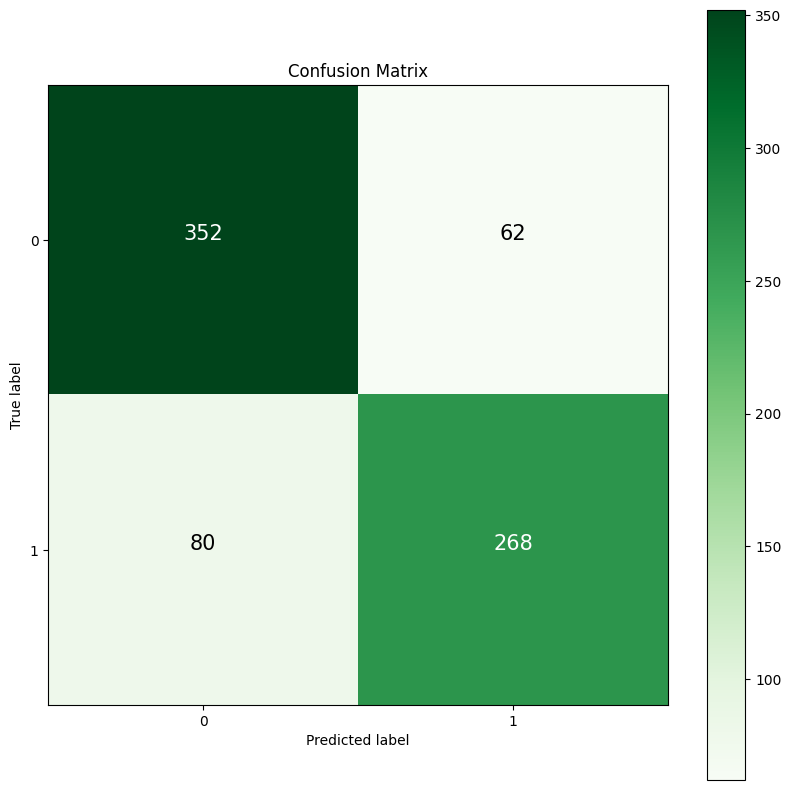

In [75]:
# Visualize the predictions with the confusion matrix
ModelEvaluation.make_confusion_matrix(val_labels, model_6_preds)

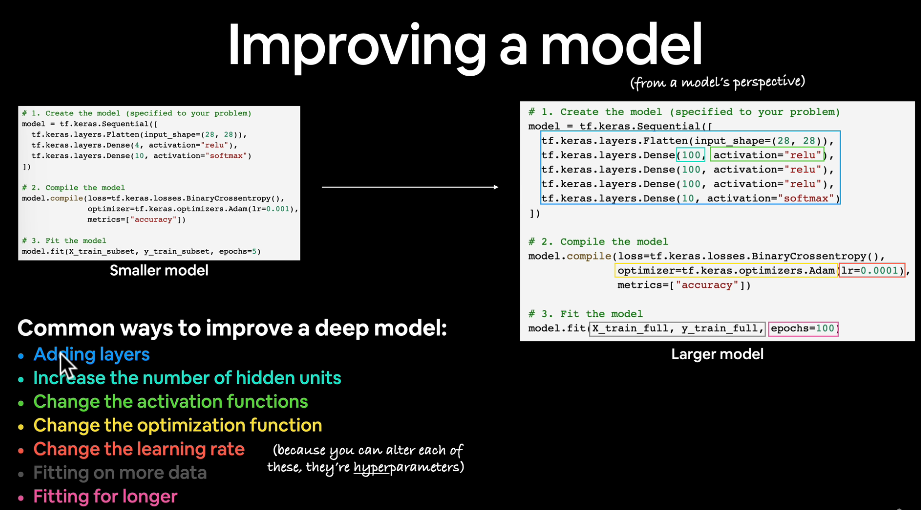

### Model_7: TensorFlow Hub Pretrained Feature Extractor (10% of Data)

Often in Machine Learning we don't have enough data to train the models so let's look at how our model performs if we had only 10% of the data.

Transfer Learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, replicate `model_6` except we'll train it on 10% of the data.

In [77]:
# Create subsets of 10% of training data
train_10_percent = train_df[['text', 'target']].sample(frac=0.1, random_state=42)
train_10_percent.head()

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1
